In [1]:
#importing necessary libraries
from api.mapbox_api_driving import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod
from collections import defaultdict
from shapely.ops import unary_union

In [2]:
#reading in library branch and population demographics, both with geometry data
branchInfo = gpd.read_file('../data/clean/branches.csv')
censusTracts = pd.read_csv('../data/clean/population_demographics.csv')

In [3]:
censusTracts.shape

(869, 63)

In [4]:
branchInfo.loc[branchInfo['BRANCH'] == 'Roosevelt']

,BRANCH,HOURS OF OPERATION,ADDRESS,CITY,STATE,ZIP,PHONE,WEBSITE,LOCATION,PERMANENTLY_CLOSED,geometry
60,Roosevelt,,1101 W. Taylor Street,Chicago,IL,60607,,,"(41.86943838326072, -87.6544586134924)",1,None


In [5]:
branchInfo = branchInfo.drop([60,60])
branchInfo = branchInfo.set_index('BRANCH')
branchInfo = branchInfo.reset_index()
branchInfo

,BRANCH,HOURS OF OPERATION,ADDRESS,CITY,STATE,ZIP,PHONE,WEBSITE,LOCATION,PERMANENTLY_CLOSED,geometry
0,Albany Park,"Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",3401 W. Foster Ave.,Chicago,IL,60625,(773) 539-5450,https://www.chipublib.org/locations/3/,"(41.97557881655979, -87.71361314512697)",0,None
1,Altgeld,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",955 E. 131st Street,Chicago,IL,60827,(312) 747-3270,https://www.chipublib.org/locations/4/,"(41.65719847558056, -87.59883829075173)",0,None
2,Archer Heights,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",5055 S. Archer Ave.,Chicago,IL,60632,(312) 747-9241,https://www.chipublib.org/locations/5/,"(41.80110836194246, -87.72648385568911)",0,None
3,Austin,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",5615 W. Race Ave.,Chicago,IL,60644,(312) 746-5038,https://www.chipublib.org/locations/6/,"(41.88917312206642, -87.7658203582574)",0,None
4,Austin-Irving,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",6100 W. Irving Park Rd.,Chicago,IL,60634,(312) 744-6222,https://www.chipublib.org/locations/7/,"(41.95312267684315, -87.77928489355646)",0,None
...,...,...,...,...,...,...,...,...,...,...,...
76,West Pullman,"Mon. & Wed., Noon-8; Tue. & Thu., 10-6; Fri. &...",830 W. 119th St.,Chicago,IL,60643,(312) 747-1425,https://www.chipublib.org/locations/78/,"(41.67790647382097, -87.6431683153105)",0,None
77,West Town,"Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",1625 W. Chicago Ave.,Chicago,IL,60622,(312) 743-0450,https://www.chipublib.org/locations/79/,"(41.89594730478282, -87.66829305460979)",0,None
78,"Whitney M. Young, Jr.","Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",415 East 79th St.,Chicago,IL,60619,(312) 747-0039,https://www.chipublib.org/locations/80/,"(41.7510184591363, -87.61495065361933)",0,None
79,Woodson Regional Library,"Mon. - Thurs., 9-8; Fri. & Sat., 9-5; Sun., 1-5",9525 S. Halsted St.,Chicago,IL,60628,(312) 747-6900,https://www.chipublib.org/locations/81/,"(41.720694885749005, -87.64304817213312)",0,None


In [6]:
branchCopy = branchInfo

In [7]:
branchCopy[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchCopy['LOCATION']]
branchCopy = branchCopy.drop(columns='LOCATION')


In [8]:
#removing unecessary columns from branchInfo
branchInfo = branchInfo.drop(columns = ['HOURS OF OPERATION', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE','PERMANENTLY_CLOSED'])
#removing unecessary columns from censusTracts
censusTracts = censusTracts[['geoid','geometry','qualifying name']]

In [9]:
#converting censusTracts to a geodataframe (we could not load it as one since it already had a geometry column so we are simply
#converting the geometry column to a proper gpd geometry column).
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

In [10]:
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


In [11]:
#helper method to ensure that two polygons overlap before getting the intersection. Gets the intersection then calculates
#the percent of overlapping area for a census tract and saves it to a dictionary with the census tract geo-id as the key and
#the percent as the value.
def check(polygon1, df, geoname, dictionary, key, iso_dict, branchname):
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            iso_dict[df.loc[i, key]] = overlapPolygon
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'Area']
            dictionary[df.loc[i, key]] = propOverlap
            
            
            if len(df.loc[i, 'polygons in census']) > 0:
                hold = (df.loc[i, 'polygons in census'][0]).copy()
                c = len(hold.items())
                hold[c] = overlapPolygon
                df.loc[i, 'polygons in census']= [hold]
                
                hold = (df.loc[i, 'area coverage of each polygon in census'][0]).copy()
                c = len(hold.items())
                hold[branchname] = propOverlap
                df.loc[i, 'area coverage of each polygon in census']= [hold]
 
 
            else:
                first = {0:overlapPolygon}
                df.loc[i, 'polygons in census'] = [first]
                
                first = {branchname:propOverlap}
                df.loc[i, 'area coverage of each polygon in census'] = [first]
            
    return dictionary


In [12]:
#sets the crs of gpd types
def geoSetup(gdf):
    
    gdf = gdf.set_crs('EPSG:4326')
    

In [13]:
#cdf = gdf of geometry area which you want to get the coverage score
#idf = gdf of points for which you want to get an isochrone and dictionary of percent of overlap in cdf areas
#scoreString = a string that is the name of the coverage score column you choose
#dictString = a string that is the name of the dictionary column you choose
#cgs = a string that is the name of the geometry column in the cdf
#igs = a string that is the name of the geometry column in the idf
#lat = a string that is the name of the latitude column in the idf
#lon = a string that is the name of the longitude column in the idf
#key = a string that is the name of the column in the cdf that you want to represent the key of the dictionary
#travelTime = an integer of the amount of time traveled you wish to calculate the isochrone

def appendADS(cdf, idf, scoreString, dictString, cgs, igs, lat, lon, key, travelTime):
    api = MapboxAPI()
    cdf[scoreString] = 0.0
    cdf['polygons in census'] = np.empty((len(cdf), 0)).tolist()
    cdf['area coverage of each polygon in census'] = np.empty((len(cdf), 0)).tolist()
    idf['number of census tracts reached'] = 0
    idf[dictString] = ''
    censusAreas = []
    global geod 
    geod = Geod(ellps='WGS84')
   
    geoSetup(cdf)
    geoSetup(idf)
   
    for index, row in cdf.iterrows():
        poly_area, poly_perimeter = geod.geometry_area_perimeter(row[cgs])
        poly_area = poly_area*-1
        censusAreas.append(poly_area)
    
    cdf['Area'] = censusAreas

    
   
    for i in range(len(idf)):
        # Create a new dictionary for tracking isochrones
        iso_dict = defaultdict(list)
        dictionary = {}
        api_response =  api.get_data((idf.loc[i,lat],idf.loc[i,lon]), travelTime)
        idf.loc[i,igs] = shape(api_response)
        dictionary = check(idf.loc[i,igs], cdf, cgs, dictionary, key, iso_dict, idf.loc[i,'BRANCH'])
        idf.loc[i,dictString] = [dictionary]
        idf.loc[i,'iso geometries'] = [iso_dict]
        idf.loc[i, 'number of census tracts reached'] = len(dictionary.items())
        
        for j in range(len(cdf)):
             if dictionary.get(cdf.loc[j, key]) != None:
                score = cdf.loc[j, scoreString]
                cdf.loc[j, scoreString] = score + dictionary.get(cdf.loc[j, key])
            
    for i in range(len(cdf)):
        if len(cdf.loc[i, 'polygons in census']) > 0:
            gl = []
            cdf.loc[i, 'number of polygons in census tract'] = len(cdf.loc[i, 'polygons in census'][0])
            toMerge = (cdf.loc[i, 'polygons in census'][0]).copy()
            for tract_key, polygons in toMerge.items():
                gl.append(polygons)
            merged_geom = unary_union(gl)
            merged_area, _ = geod.geometry_area_perimeter(merged_geom)
            merged_area *= -1
            area_val = merged_area / cdf.loc[i,'Area']
            cdf.loc[i, 'percent covered by at least one library'] = area_val
        
        if len(cdf.loc[i, 'area coverage of each polygon in census']) > 0:
            toAddPerc = 0
            toAdd = (cdf.loc[i, 'area coverage of each polygon in census'][0]).copy()
            for tract_key, percent in toAdd.items():
                toAddPerc = toAddPerc + percent
            cdf.loc[i, 'added percentages'] = toAddPerc
            
        else:
            cdf.loc[i, 'added percentages'] = 0
            cdf.loc[i, 'percent covered by at least one library'] = 0
            cdf.loc[i, 'number of polygons in census tract'] = 0
                
 

In [14]:
appendADS(censusTracts,branchInfo, 'raw score', 'list of dict','geometry','geometry','LATITUDE','LONGITUDE','geoid', 10)

In [15]:
branchInfo

,BRANCH,LOCATION,geometry,Latitude,Longitude,LATITUDE,LONGITUDE,number of census tracts reached,list of dict,iso geometries
0,Albany Park,"(41.97557881655979, -87.71361314512697)","POLYGON ((-87.71161 42.01873, -87.71216 42.017...",41.975579,-87.713613,41.975579,-87.713613,62,"[{17031160700: 0.4827774497174522, 17031831100...","{17031160700: POLYGON ((-87.697613 41.953803, ..."
1,Altgeld,"(41.65719847558056, -87.59883829075173)","POLYGON ((-87.62484 41.74038, -87.62523 41.731...",41.657198,-87.598838,41.657198,-87.598838,43,"[{17031826500: 1.0, 17031825801: 1.0, 17031826...",[{17031826500: POLYGON ((-87.61439644367273 41...
2,Archer Heights,"(41.80110836194246, -87.72648385568911)","POLYGON ((-87.72348 41.83857, -87.72448 41.838...",41.801108,-87.726484,41.801108,-87.726484,67,"[{17031561000: 0.04905076976432162, 1703156090...","[{17031561000: POLYGON ((-87.782757 41.790108,..."
3,Austin,"(41.88917312206642, -87.7658203582574)","POLYGON ((-87.76582 41.92419, -87.76801 41.922...",41.889173,-87.765820,41.889173,-87.765820,63,"[{17031813500: 1.0, 17031813400: 1.0, 17031813...",[{17031813500: MULTIPOLYGON (((-87.773144 41.8...
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)","POLYGON ((-87.78728 41.98561, -87.78807 41.985...",41.953123,-87.779285,41.953123,-87.779285,63,"[{17031831600: 0.07202303980372479, 1703119130...",[{17031831600: MULTIPOLYGON (((-87.798285 41.9...
...,...,...,...,...,...,...,...,...,...,...
76,West Pullman,"(41.67790647382097, -87.6431683153105)","POLYGON ((-87.62517 41.75922, -87.62552 41.739...",41.677906,-87.643168,41.677906,-87.643168,62,"[{17031823304: 0.32497112370871845, 1703174040...",[{17031823304: MULTIPOLYGON (((-87.69102496333...
77,West Town,"(41.89594730478282, -87.66829305460979)","POLYGON ((-87.68529 41.92720, -87.68669 41.927...",41.895947,-87.668293,41.895947,-87.668293,106,"[{17031843200: 0.011485249602696038, 170313404...","[{17031843200: POLYGON ((-87.645647 41.849947,..."
78,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)","POLYGON ((-87.63095 41.84934, -87.63142 41.845...",41.751018,-87.614951,41.751018,-87.614951,136,"[{17031750500: 0.003922645587112058, 170317506...","[{17031750500: POLYGON ((-87.661776 41.688844,..."
79,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)","POLYGON ((-87.63105 41.80671, -87.63123 41.795...",41.720695,-87.643048,41.720695,-87.643048,106,"[{17031823400: 0.10923853816229846, 1703182350...",[{17031823400: POLYGON ((-87.68588291969066 41...


In [16]:
file_path = '../data/clean/branchDataWithReachCount.csv'

branchInfo.to_csv(file_path, index=False)

In [17]:
branchInfo.sort_values(by = 'number of census tracts reached', ascending=False)

,BRANCH,LOCATION,geometry,Latitude,Longitude,LATITUDE,LONGITUDE,number of census tracts reached,list of dict,iso geometries
78,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)","POLYGON ((-87.63095 41.84934, -87.63142 41.845...",41.751018,-87.614951,41.751018,-87.614951,136,"[{17031750500: 0.003922645587112058, 170317506...","[{17031750500: POLYGON ((-87.661776 41.688844,..."
37,Kelly,"(41.78202569697298, -87.63738794358196)","POLYGON ((-87.64439 41.85409, -87.64475 41.853...",41.782026,-87.637388,41.782026,-87.637388,135,"[{17031834000: 0.07935283634994997, 1703148010...","[{17031834000: POLYGON ((-87.624388 41.721943,..."
61,Sherman Park,"(41.79476901885989, -87.65502837616037)","POLYGON ((-87.63003 41.85080, -87.63089 41.850...",41.794769,-87.655028,41.794769,-87.655028,124,"[{17031842400: 0.001635900579839759, 170317108...","[{17031842400: POLYGON ((-87.625028 41.750038,..."
30,Hall,"(41.807377846345496, -87.62263720177272)","POLYGON ((-87.61764 41.86942, -87.61920 41.867...",41.807378,-87.622637,41.807378,-87.622637,120,"[{17031691200: 0.023279572705688954, 170316915...","[{17031691200: POLYGON ((-87.625637 41.754976,..."
17,Chinatown,"(41.85412074173438, -87.63195792246246)","POLYGON ((-87.64596 41.89214, -87.65289 41.892...",41.854121,-87.631958,41.854121,-87.631958,119,"[{17031842400: 0.0012768388636586997, 17031691...","[{17031842400: POLYGON ((-87.624958 41.750085,..."
...,...,...,...,...,...,...,...,...,...,...
50,Mount Greenwood,"(41.693015814018004, -87.70102477600602)","POLYGON ((-87.70203 41.74785, -87.70416 41.743...",41.693016,-87.701025,41.693016,-87.701025,42,"[{17031823303: 1.0, 17031823304: 1.0, 17031740...","[{17031823303: POLYGON ((-87.720304 41.683963,..."
55,Oriole Park,"(41.978098111742476, -87.81420029973704)","POLYGON ((-87.86720 42.01659, -87.86723 42.015...",41.978098,-87.814200,41.978098,-87.814200,40,"[{17031170800: 1.125637556056093e-06, 17031170...","[{17031170800: POLYGON ((-87.8142 41.94511, -8..."
28,Garfield Ridge,"(41.792915800399726, -87.78013459023622)","POLYGON ((-87.76314 41.83114, -87.76541 41.829...",41.792916,-87.780135,41.792916,-87.780135,36,"[{17031820502: 1.0, 17031640500: 1.0, 17031640...",[{17031820502: MULTIPOLYGON (((-87.800805 41.7...
32,Hegewisch,"(41.65927659861025, -87.54881978393514)","POLYGON ((-87.55982 41.71340, -87.56086 41.712...",41.659277,-87.548820,41.659277,-87.548820,23,"[{17031825801: 1.0, 17031826401: 0.14828824782...","[{17031825801: POLYGON ((-87.578387 41.644729,..."


In [18]:
censusTracts

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,number of polygons in census tract,percent covered by at least one library,added percentages
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.72096 41.68395, -87.72030 41.683...",2.000000,"[{0: POLYGON ((-87.720304 41.683963, -87.72006...","[{'Mount Greenwood': 1.0, 'Walker': 1.0}]",1.081697e+00,2.0,1.000000,2.000000
1,17031823304,"Census Tract 8233.04, Cook County, Illinois","MULTIPOLYGON (((-87.72004 41.68397, -87.72006 ...",2.442526,[{0: MULTIPOLYGON (((-87.69347162680522 41.698...,"[{'Beverly': 0.09811047560101846, 'Mount Green...",3.526503e+05,5.0,1.000002,2.442526
2,17031740400,"Census Tract 7404, Cook County, Illinois","POLYGON ((-87.72008 41.69127, -87.71937 41.691...",1.916289,"[{0: POLYGON ((-87.719372 41.691286, -87.71913...","[{'Mount Greenwood': 1.0, 'Scottsdale': 0.0096...",2.782659e+06,5.0,1.000000,1.916289
3,17031740300,"Census Tract 7403, Cook County, Illinois","POLYGON ((-87.72043 41.69857, -87.72007 41.698...",3.173875,"[{0: POLYGON ((-87.701146 41.692471, -87.70203...","[{'Beverly': 0.1224093070115254, 'Mount Greenw...",1.319688e+06,5.0,1.000000,3.173875
4,17031822802,"Census Tract 8228.02, Cook County, Illinois","MULTIPOLYGON (((-87.72075 41.70204, -87.72075 ...",4.000000,[{0: MULTIPOLYGON (((-87.72074518791808 41.701...,"[{'Mount Greenwood': 1.0, 'Scottsdale': 1.0, '...",1.577396e+01,4.0,1.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...
864,17031320400,"Census Tract 3204, Cook County, Illinois","POLYGON ((-87.62764 41.88206, -87.62759 41.882...",4.550656,"[{0: POLYGON ((-87.621507 41.8734, -87.620745 ...","[{'Chicago Bee': 0.0671065109581762, 'Chinatow...",8.033379e+05,12.0,1.000000,4.550656
865,17031320101,"Census Tract 3201.01, Cook County, Illinois","POLYGON ((-87.62086 41.88188, -87.62082 41.882...",2.512049,"[{0: POLYGON ((-87.613129 41.883194, -87.61390...",[{'Harold Washington Library Center': 0.986423...,4.902799e+05,4.0,0.999906,2.512049
866,17031081403,"Census Tract 814.03, Cook County, Illinois","MULTIPOLYGON (((-87.62431 41.88911, -87.62431 ...",2.133354,"[{0: MULTIPOLYGON (((-87.612186 41.885474, -87...",[{'Harold Washington Library Center': 0.706927...,5.956278e+05,6.0,0.762938,2.133354
867,17031081402,"Census Tract 814.02, Cook County, Illinois","POLYGON ((-87.61754 41.89345, -87.61716 41.893...",1.527932,[{0: POLYGON ((-87.61142616979905 41.889713598...,[{'Harold Washington Library Center': 0.536911...,5.776787e+05,4.0,0.568678,1.527932


In [19]:
censusTracts.sort_values(by = 'number of polygons in census tract', ascending = False)

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,number of polygons in census tract,percent covered by at least one library,added percentages
346,17031843200,"Census Tract 8432, Cook County, Illinois","POLYGON ((-87.67780 41.85214, -87.67633 41.852...",6.590448,"[{0: MULTIPOLYGON (((-87.667484 41.83801, -87....","[{'Archer Heights': 0.004130637013230658, 'Bac...",3.093995e+06,20.0,1.0,6.590448
300,17031835600,"Census Tract 8356, Cook County, Illinois","POLYGON ((-87.63577 41.80905, -87.63572 41.809...",10.886379,"[{0: POLYGON ((-87.63257 41.805731, -87.63357 ...","[{'Back of the Yards': 0.09539858933647186, 'B...",9.175009e+05,20.0,1.0,10.886379
231,17031691100,"Census Tract 6911, Cook County, Illinois","POLYGON ((-87.63550 41.75988, -87.63477 41.759...",8.570395,"[{0: POLYGON ((-87.631917 41.758393, -87.62800...","[{'Avalon': 0.21630299568435393, 'Brainerd': 0...",6.757429e+05,19.0,1.0,8.570395
109,17031691200,"Census Tract 6912, Cook County, Illinois","POLYGON ((-87.63982 41.75615, -87.63969 41.756...",7.812188,"[{0: MULTIPOLYGON (((-87.631471 41.750858, -87...","[{'Avalon': 0.4616098851423038, 'Brainerd': 0....",1.013723e+06,19.0,1.0,7.812188
352,17031340400,"Census Tract 3404, Cook County, Illinois","POLYGON ((-87.63428 41.84545, -87.63428 41.845...",12.672574,"[{0: POLYGON ((-87.631545 41.839493, -87.63215...","[{'Blackstone': 0.26472193042403597, 'Canaryvi...",2.903134e+05,18.0,1.0,12.672574
...,...,...,...,...,...,...,...,...,...,...
817,17031770500,"Census Tract 7705, Cook County, Illinois","MULTIPOLYGON (((-87.92056 42.00483, -87.92061 ...",0.000000,[],[],1.799139e+05,0.0,0.0,0.000000
795,17043840801,"Census Tract 8408.01, DuPage County, Illinois","MULTIPOLYGON (((-87.93906 41.95849, -87.93900 ...",0.000000,[],[],2.092095e+04,0.0,0.0,0.000000
796,17043840802,"Census Tract 8408.02, DuPage County, Illinois","POLYGON ((-87.93928 41.96089, -87.93923 41.960...",0.000000,[],[],3.274787e+03,0.0,0.0,0.000000
797,17043840000,"Census Tract 8400, DuPage County, Illinois","POLYGON ((-87.93897 41.99352, -87.93893 41.993...",0.000000,[],[],6.849187e+06,0.0,0.0,0.000000


In [20]:
censusTracts.sort_values(by = 'percent covered by at least one library', ascending = False)

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,number of polygons in census tract,percent covered by at least one library,added percentages
441,17031813301,"Census Tract 8133.01, Cook County, Illinois","MULTIPOLYGON (((-87.75843 41.86569, -87.75786 ...",3.244526,"[{0: MULTIPOLYGON (((-87.757857 41.865701, -87...","[{'Austin': 1.0, 'Douglass': 1.0, 'Legler Regi...",1.221551e+01,5.0,1.000408,3.244526
18,17031826401,"Census Tract 8264.01, Cook County, Illinois","MULTIPOLYGON (((-87.61231 41.64460, -87.61226 ...",1.305035,"[{0: MULTIPOLYGON (((-87.612257 41.644602, -87...","[{'Altgeld': 1.0, 'Hegewisch': 0.1482882478227...",2.270740e+03,5.0,1.000370,1.305035
5,17031823400,"Census Tract 8234, Cook County, Illinois","POLYGON ((-87.68586 41.67721, -87.68592 41.677...",3.109239,[{0: POLYGON ((-87.68592233437428 41.677209685...,"[{'Mount Greenwood': 1.0, 'Walker': 1.0, 'West...",3.390550e-02,4.0,1.000102,3.109239
792,17031807900,"Census Tract 8079, Cook County, Illinois","MULTIPOLYGON (((-87.76203 42.00237, -87.76204 ...",3.906705,[{0: MULTIPOLYGON (((-87.7391943544673 41.9972...,"[{'Albany Park': 0.039414075536064457, 'Budlon...",4.173064e+01,6.0,1.000072,3.906705
17,17031825801,"Census Tract 8258.01, Cook County, Illinois","POLYGON ((-87.57848 41.64473, -87.57839 41.644...",2.450421,"[{0: POLYGON ((-87.578387 41.644729, -87.57788...","[{'Altgeld': 1.0, 'Hegewisch': 1.0, 'Pullman':...",1.419256e+03,4.0,1.000039,2.450421
...,...,...,...,...,...,...,...,...,...,...
796,17043840802,"Census Tract 8408.02, DuPage County, Illinois","POLYGON ((-87.93928 41.96089, -87.93923 41.960...",0.000000,[],[],3.274787e+03,0.0,0.000000,0.000000
817,17031770500,"Census Tract 7705, Cook County, Illinois","MULTIPOLYGON (((-87.92056 42.00483, -87.92061 ...",0.000000,[],[],1.799139e+05,0.0,0.000000,0.000000
798,17031811701,"Census Tract 8117.01, Cook County, Illinois","MULTIPOLYGON (((-87.92020 41.95334, -87.92020 ...",0.000000,[],[],2.860783e+05,0.0,0.000000,0.000000
797,17043840000,"Census Tract 8400, DuPage County, Illinois","POLYGON ((-87.93897 41.99352, -87.93893 41.993...",0.000000,[],[],6.849187e+06,0.0,0.000000,0.000000


In [21]:
censusTracts['raw score norm'] = censusTracts['raw score']
censusTracts.loc[censusTracts['raw score norm'] > 1, 'raw score norm'] = 1.0
censusTracts['weighted score'] = censusTracts['number of polygons in census tract'] * censusTracts['percent covered by at least one library']
censusTracts.sort_values(by = 'weighted score', ascending = False)

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,number of polygons in census tract,percent covered by at least one library,added percentages,raw score norm,weighted score
300,17031835600,"Census Tract 8356, Cook County, Illinois","POLYGON ((-87.63577 41.80905, -87.63572 41.809...",10.886379,"[{0: POLYGON ((-87.63257 41.805731, -87.63357 ...","[{'Back of the Yards': 0.09539858933647186, 'B...",9.175009e+05,20.0,1.0,10.886379,1.0,20.000004
346,17031843200,"Census Tract 8432, Cook County, Illinois","POLYGON ((-87.67780 41.85214, -87.67633 41.852...",6.590448,"[{0: MULTIPOLYGON (((-87.667484 41.83801, -87....","[{'Archer Heights': 0.004130637013230658, 'Bac...",3.093995e+06,20.0,1.0,6.590448,1.0,20.000000
231,17031691100,"Census Tract 6911, Cook County, Illinois","POLYGON ((-87.63550 41.75988, -87.63477 41.759...",8.570395,"[{0: POLYGON ((-87.631917 41.758393, -87.62800...","[{'Avalon': 0.21630299568435393, 'Brainerd': 0...",6.757429e+05,19.0,1.0,8.570395,1.0,19.000000
109,17031691200,"Census Tract 6912, Cook County, Illinois","POLYGON ((-87.63982 41.75615, -87.63969 41.756...",7.812188,"[{0: MULTIPOLYGON (((-87.631471 41.750858, -87...","[{'Avalon': 0.4616098851423038, 'Brainerd': 0....",1.013723e+06,19.0,1.0,7.812188,1.0,19.000000
319,17031835500,"Census Tract 8355, Cook County, Illinois","POLYGON ((-87.63617 41.82359, -87.63612 41.823...",11.051868,"[{0: POLYGON ((-87.63557 41.810788, -87.63357 ...","[{'Back of the Yards': 0.06209327481610603, 'C...",9.140149e+05,18.0,1.0,11.051868,1.0,18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
817,17031770500,"Census Tract 7705, Cook County, Illinois","MULTIPOLYGON (((-87.92056 42.00483, -87.92061 ...",0.000000,[],[],1.799139e+05,0.0,0.0,0.000000,0.0,0.000000
795,17043840801,"Census Tract 8408.01, DuPage County, Illinois","MULTIPOLYGON (((-87.93906 41.95849, -87.93900 ...",0.000000,[],[],2.092095e+04,0.0,0.0,0.000000,0.0,0.000000
796,17043840802,"Census Tract 8408.02, DuPage County, Illinois","POLYGON ((-87.93928 41.96089, -87.93923 41.960...",0.000000,[],[],3.274787e+03,0.0,0.0,0.000000,0.0,0.000000
797,17043840000,"Census Tract 8400, DuPage County, Illinois","POLYGON ((-87.93897 41.99352, -87.93893 41.993...",0.000000,[],[],6.849187e+06,0.0,0.0,0.000000,0.0,0.000000


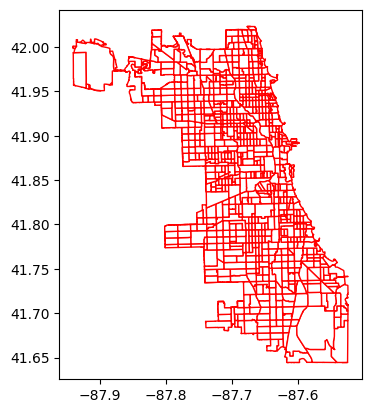

In [22]:
branchCopy = gpd.GeoDataFrame(
     branchCopy, geometry=gpd.points_from_xy(branchCopy.Longitude, branchCopy.Latitude), crs="EPSG:3435")

base = censusTracts.plot(color='white', edgecolor='red')


<Axes: title={'center': 'Raw Score'}>

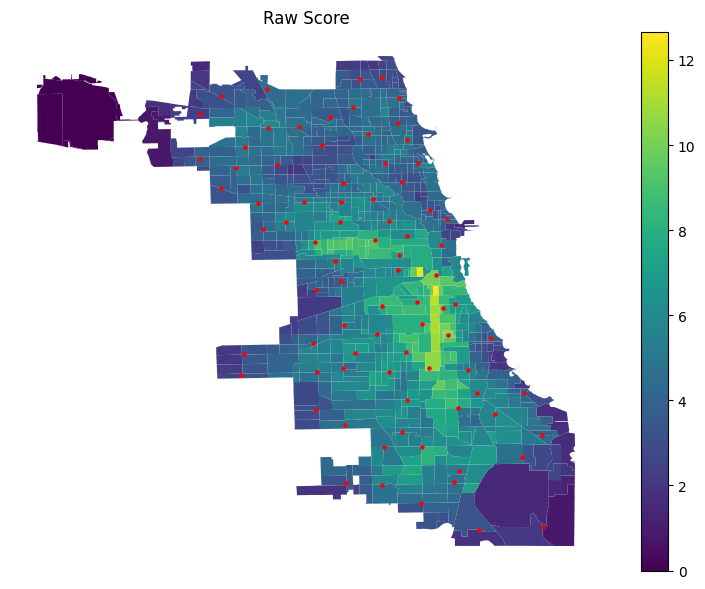

In [23]:
ax = censusTracts.plot(column = 'raw score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Raw Score")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5, edgecolor='red')


<Axes: title={'center': 'Raw Score Normalized'}>

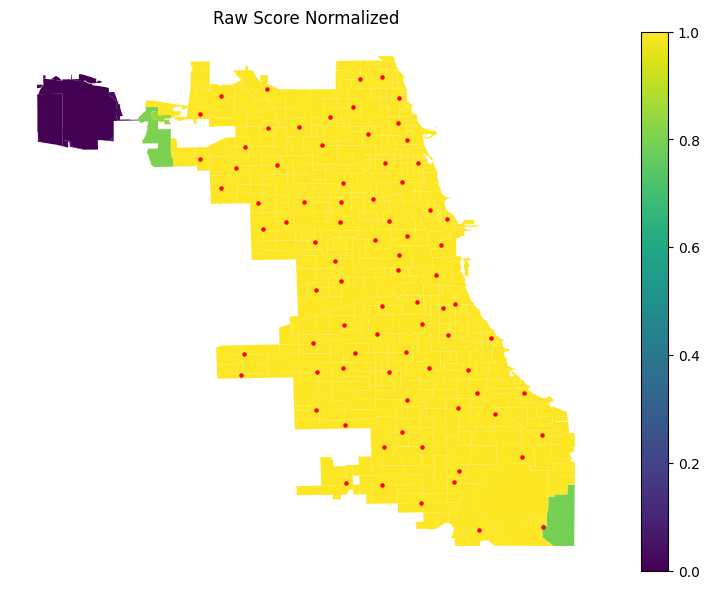

In [24]:
ax = censusTracts.plot(column = 'raw score norm', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Raw Score Normalized")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5, edgecolor='red')


<Axes: title={'center': 'Percent Access to at Least One Library: 10 Minutes Driving'}>

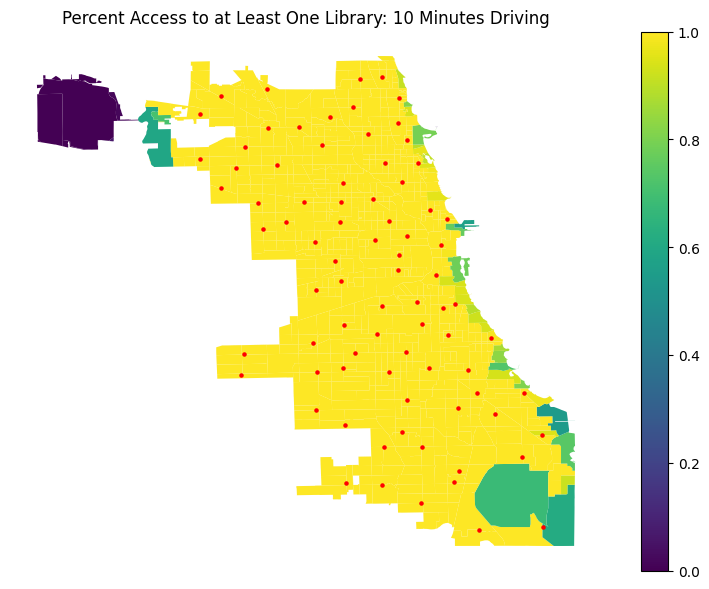

In [25]:
ax = censusTracts.plot(column = 'percent covered by at least one library', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent Access to at Least One Library: 10 Minutes Driving")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)


<Axes: title={'center': 'Weighted Score'}>

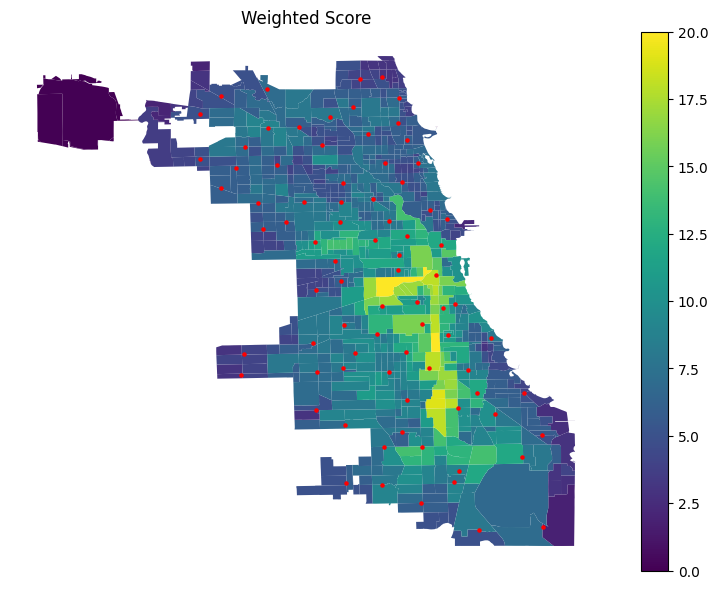

In [26]:
ax = censusTracts.plot(column = 'weighted score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Weighted Score")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)


In [27]:
demographics = pd.read_csv('../data/clean/census_demos.csv')
demographics

,geoid,qualifying name,geometry,total population,Percent: under 5 years,Percent: 5 to 9 years,Percent: 10 to 14 years,Percent: 15 to 19 years,Percent: 20 to 24 years,Percent: 25 to 29 years,...,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.720963 41.683952, -87.720304 41....",4059,0.047056,0.099039,0.075634,0.052230,0.040404,0.069475,...,0.912801,0.087199,0.806432,0.795763,0.078098,0.009855,0.000000,0.0,0.072924,0.043360
1,17031823304,"Census Tract 8233.04, Cook County, Illinois",MULTIPOLYGON (((-87.72003618903081 41.68396731...,6316,0.060798,0.063965,0.094205,0.057948,0.056365,0.066498,...,0.787775,0.212225,0.691724,0.603388,0.304465,0.001742,0.008233,0.0,0.037365,0.044807
2,17031740400,"Census Tract 7404, Cook County, Illinois","POLYGON ((-87.72008 41.691274, -87.719372 41.6...",4738,0.067750,0.060996,0.082946,0.063529,0.068383,0.064373,...,0.918216,0.081784,0.836431,0.879907,0.058041,0.000000,0.032714,0.0,0.000000,0.029337
3,17031740300,"Census Tract 7403, Cook County, Illinois","POLYGON ((-87.720431 41.698569, -87.720066 41....",5017,0.068567,0.073749,0.069962,0.042456,0.028304,0.067570,...,0.948943,0.051057,0.929345,0.906119,0.015547,0.000000,0.008372,0.0,0.033486,0.036476
4,17031822802,"Census Tract 8228.02, Cook County, Illinois","MULTIPOLYGON (((-87.720752 41.702042, -87.7207...",3750,0.055200,0.114667,0.068000,0.081600,0.030933,0.027467,...,0.885246,0.114754,0.850898,0.849067,0.049333,0.001333,0.018933,0.0,0.022400,0.058933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,17031320400,"Census Tract 3204, Cook County, Illinois","POLYGON ((-87.627636 41.882057, -87.627594 41....",3058,0.003924,0.003597,0.000000,0.300523,0.325049,0.050033,...,NaN,NaN,0.904269,0.678548,0.107914,0.000000,0.149444,0.0,0.015043,0.049052
865,17031320101,"Census Tract 3201.01, Cook County, Illinois","POLYGON ((-87.620855 41.881881, -87.620825 41....",7952,0.026157,0.038481,0.005282,0.020372,0.032193,0.095825,...,0.953413,0.046587,0.791776,0.594693,0.067404,0.000000,0.234406,0.0,0.053697,0.049799
866,17031081403,"Census Tract 814.03, Cook County, Illinois","MULTIPOLYGON (((-87.624311 41.889115, -87.6243...",8984,0.028718,0.002894,0.005677,0.000000,0.108081,0.220837,...,0.996585,0.003415,0.920150,0.616874,0.019368,0.000000,0.306879,0.0,0.025378,0.031500
867,17031081402,"Census Tract 814.02, Cook County, Illinois","POLYGON ((-87.617537 41.893453, -87.617164 41....",5613,0.051309,0.042936,0.010868,0.012649,0.055407,0.155175,...,0.969296,0.030704,0.918122,0.619277,0.049172,0.003029,0.240869,0.0,0.018172,0.069482


In [28]:
censusTracts = censusTracts.drop(columns = ['qualifying name','geometry','polygons in census','area coverage of each polygon in census'])

In [29]:
ctm = censusTracts.merge(demographics, on = 'geoid')
ctmcopy = ctm

In [30]:
ctm.set_index('geoid', inplace = True)


In [31]:
ctm = ctm.drop(columns = ['qualifying name','geometry'])

In [32]:
corrRawScore = ctm.corrwith(ctm['raw score'])
cRaw = corrRawScore.to_frame()
cRaw=cRaw.sort_values(by = 0)
cRaw.drop(axis = 'index', index=['weighted score', 'raw score norm', 'percent covered by at least one library', 'added percentages'])

,0
Percent: White Alone,-0.437094
Percent Population in Labor Force 16+: Employed,-0.368057
Percent Ages 18-64: At or Above Poverty Level,-0.352723
total population,-0.331553
workers 16 years and over,-0.329104
...,...
Percent Ages 18-64: Living in Poverty,0.352723
Percent Population in Labor Force 16+: Unemployed,0.368057
Percent: Black or African American Alone,0.397140
number of polygons in census tract,0.840805


In [33]:
corrRawScoreN = ctm.corrwith(ctm['raw score norm'])
cRawN = corrRawScoreN.to_frame()
cRawN = cRawN.sort_values(by = 0)
cRawN.drop(axis = 'index', index=['weighted score', 'raw score', 'percent covered by at least one library', 'added percentages'])

,0
Area,-0.210721
Percent Workers 16+: Drove Alone,-0.176027
Percent Renter-Occupied Housing: 3 Vehicles,-0.167835
"Percent Workers 16+: Car, Truck, or Van",-0.163412
Percent Owner and Renter Occupied Housing: 3 Vehicles,-0.157622
...,...
Percent Renter-Occupied Housing: No Vehicles,0.130036
average commute to work (in min),0.155853
Percent Workers 16+: Public Transportation (Includes Taxi),0.170630
number of polygons in census tract,0.226719


In [34]:
corrWeightedScore = ctm.corrwith(ctm['weighted score'])
cWeight = corrWeightedScore.to_frame()
cWeight = cWeight.sort_values(by = 0)
cWeight.drop(axis = 'index', index=['raw score norm', 'raw score', 'percent covered by at least one library', 'added percentages'])

,0
Percent: White Alone,-0.419378
Percent Population in Labor Force 16+: Employed,-0.337077
Percent Ages 18-64: At or Above Poverty Level,-0.332034
Percent Owner and Renter Occupied Housing: 2 Vehicles,-0.259539
workers 16 years and over,-0.252341
...,...
Percent Ages 18-64: Living in Poverty,0.332034
Percent Population in Labor Force 16+: Unemployed,0.337077
Percent: Black or African American Alone,0.368695
number of polygons in census tract,0.996733


In [35]:
corrCovPer = ctm.corrwith(ctm['percent covered by at least one library'])
cCovPer = corrCovPer.to_frame()
cCovPer = cCovPer.sort_values(by = 0)
cCovPer.drop(axis = 'index', index=['raw score norm', 'raw score', 'weighted score', 'added percentages'])

,0
Area,-0.294019
Percent Workers 16+: Drove Alone,-0.157160
Percent Renter-Occupied Housing: 3 Vehicles,-0.142990
"Percent Workers 16+: Car, Truck, or Van",-0.137631
Percent Renter-Occupied Housing: 2 Vehicles,-0.135549
...,...
gini index,0.101294
average commute to work (in min),0.151087
Percent Workers 16+: Public Transportation (Includes Taxi),0.151966
number of polygons in census tract,0.228151
